In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, linear_model, svm, ensemble
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn_pandas import DataFrameMapper
from helpers import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
train_raw = pd.read_csv("train.csv")
train_raw = train_raw.set_index("Id")
train_raw = train_raw.copy()

test_X_raw = pd.read_csv("test.csv")
test_X_raw = test_X_raw.set_index("Id")
test_X_raw = test_X_raw.copy()

In [3]:
train_raw.isnull().sum().sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

In [4]:
train_raw['SalePrice'].isnull().sum()

0

In [5]:
train_raw = train_raw.fillna(0)
test_X_raw = test_X_raw.fillna(0)

In [6]:
numerical, categorical = columns()

In [7]:
train_raw[categorical] = train_raw[categorical].astype('str')
train_raw[numerical] = train_raw[numerical].astype('float')
test_X_raw[categorical] = test_X_raw[categorical].astype('str')
test_X_raw[numerical] = test_X_raw[numerical].astype('float')

In [8]:
train_X_raw, train_Y_raw = train_raw[train_raw.columns[:-1]], train_raw[train_raw.columns[-1]]

In [9]:
X_raw = pd.concat([train_X_raw, test_X_raw])

In [10]:
print('train_X_raw shape:', train_X_raw.shape)
print('test_X_raw shape:', test_X_raw.shape)
print('X_raw shape:', X_raw.shape)
print('train_X_raw.shape[0] + test_X_raw.shape[0] =', train_X_raw.shape[0] + test_X_raw.shape[0])

train_X_raw shape: (1460, 79)
test_X_raw shape: (1459, 79)
X_raw shape: (2919, 79)
train_X_raw.shape[0] + test_X_raw.shape[0] = 2919


In [11]:
# Y value preprocessing

mean = 180921.1959
std = 79415.2919
skewness = 1.8829
kurtosis = 6.5363


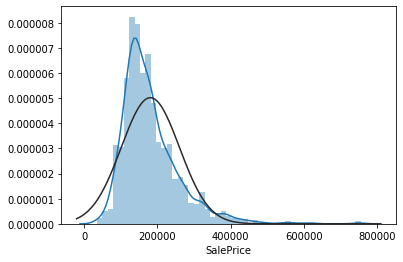

In [12]:
plt.figure()
fig01 = sns.distplot(train_Y_raw, fit = stats.norm)
mean, stdev = stats.norm.fit(train_Y_raw)
print('mean = {:.4f}\nstd = {:.4f}\nskewness = {:.4f}\nkurtosis = {:.4f}'
      .format(mean, stdev, train_Y_raw.skew(), train_Y_raw.kurtosis()))

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

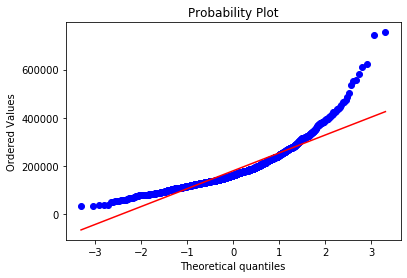

In [13]:
plt.figure()
stats.probplot(train_Y_raw, plot=plt)

In [14]:
train_Y = np.log1p(train_Y_raw).to_numpy()

mean = 12.0241
std = 0.3993
skewness = 0.1212
kurtosis = 0.8026


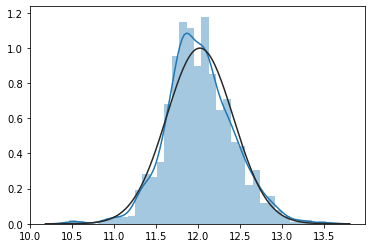

In [15]:
plt.figure()
fig02 = sns.distplot(train_Y, fit = stats.norm)
mean, stdev = stats.norm.fit(train_Y)
print('mean = {:.4f}\nstd = {:.4f}\nskewness = {:.4f}\nkurtosis = {:.4f}'
      .format(mean, stdev, stats.skew(train_Y), stats.kurtosis(train_Y)))

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

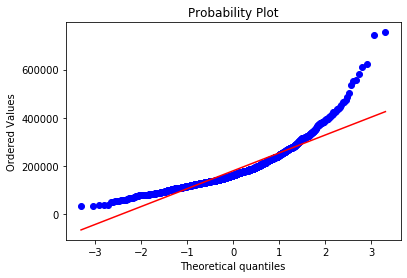

In [16]:
plt.figure()
stats.probplot(train_Y_raw, plot=plt)

In [17]:
# Feature Classification

In [18]:
feature_class = pd.read_csv('feature_class.csv', names = ['feature', 'class'])

In [19]:
feature_class['feature'] = feature_class['feature'].str.strip()
feature_class['class'] = feature_class['class'].str.strip()

In [20]:
numerical = []
nominal = []
ordinal = []

In [21]:
for i in X_raw.columns:
    if feature_class['class'][feature_class['feature']==i].values == 'Numerical': 
        numerical.append(i)
    elif feature_class['class'][feature_class['feature']==i].values == "Nominal":
        nominal.append(i)
    elif feature_class['class'][feature_class['feature']==i].values == "Ordinal":
        ordinal.append(i)

In [24]:
print('numerical:', numerical)
print()
print('nominal:', nominal)
print()
print('ordinal:', ordinal)

numerical: ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

nominal: ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

ordinal: ['Utilities', 'LandSlope', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'Kitchen

In [25]:
# Numerical Feature Skewness

In [26]:
X_raw[numerical].skew().sort_values(ascending=False)

MiscVal          21.958480
PoolArea         16.907017
LotArea          12.829025
LowQualFinSF     12.094977
3SsnPorch        11.381914
KitchenAbvGr      4.304467
BsmtFinSF2        4.148275
EnclosedPorch     4.005950
ScreenPorch       3.948723
BsmtHalfBath      3.933616
MasVnrArea        2.614936
OpenPorchSF       2.536417
WoodDeckSF        1.843380
1stFlrSF          1.470360
BsmtFinSF1        1.425963
GrLivArea         1.270010
TotalBsmtSF       1.157489
BsmtUnfSF         0.919812
2ndFlrSF          0.862118
TotRmsAbvGrd      0.758757
HalfBath          0.694924
BsmtFullBath      0.625153
BedroomAbvGr      0.326492
GarageArea        0.239380
FullBath          0.167692
LotFrontage       0.022024
GarageCars       -0.219694
dtype: float64

In [27]:
X_raw[numerical].skew().mean()

4.156579959109575

In [28]:
# X Value Transformation

In [29]:
mapper = DataFrameMapper([
    (numerical, preprocessing.StandardScaler()),
    (nominal, preprocessing.OneHotEncoder(sparse=False)),
    (ordinal, preprocessing.OrdinalEncoder())], df_out=True)

In [30]:
X = mapper.fit_transform(X_raw)

In [31]:
train_X = X.loc[train_X_raw.index].to_numpy()
test_X = X.loc[test_X_raw.index].to_numpy()

In [32]:
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, random_state=42)

In [33]:
print('train_X shape:', train_X.shape)
print('dev_X shape:', dev_X.shape)
print('train_Y shape:', train_Y.shape)
print('dev_Y shape:', dev_Y.shape)

train_X shape: (1095, 531)
dev_X shape: (365, 531)
train_Y shape: (1095,)
dev_Y shape: (365,)


In [34]:
# model 01

In [35]:
model01 = linear_model.LinearRegression()
grid01 = {'fit_intercept' : [True, False]}

In [36]:
model01, train_score01, dev_score01 = gridsearchcv(model01, grid01, train_X, train_Y, dev_X, dev_Y)

grid search best parameters: {'fit_intercept': False}
grid search best scores: -28376945086478480.0000
cv score: -355953341740465472.0000
dev score: -1496685472953105664.0000


In [37]:
y01 = np.expm1(model01.predict(test_X))

In [38]:
y01

array([118854.8909671 ,             inf, 192663.37926179, ...,
       174892.05147191, 115503.68203418, 220451.22402342])

In [ ]:
# model 02

In [39]:
model02 = linear_model.Ridge()
grid02 = {'alpha' : [0.1, 0.5, 1, 3, 5]}

In [41]:
#model01, train_score01, dev_score01 = gridsearchcv(model01, grid01, train_X, train_Y, dev_X, dev_Y)
model02, train_score02, dev_score02 = gridsearchcv(model02, grid02, train_X, train_Y, dev_X, dev_Y)

grid search best parameters: {'alpha': 5}
grid search best scores: 0.8447
cv score: 0.8447
dev score: 0.8858


In [ ]:
output_csv01 = pd.DataFrame(data=[test_X_raw.index.values, y01]).T
output_csv01.columns = ['Id', 'SalePrice']
output_csv01 = output_csv01.astype('float')
output_csv01.to_csv('./outputs/output_csv01.csv', index=False)